# Hi! This is David and Brenna's CYOA project. Check out the cool stuff we did!

## Some set-up stuff

In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from patsy import dmatrix
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator

In [2]:
cur_dir = os.path.dirname('__file__')

train = pd.read_csv(os.path.join(cur_dir, "data", "train.csv"))
test = pd.read_csv(os.path.join(cur_dir, "data", "test.csv"))
mapdata = np.loadtxt(os.path.join(cur_dir, "data", "sf_map.txt"))

### Some helper functions. Note we do all our preprocessing in one function.

In [68]:
def get_random_subset(df, n=None):
    if (n is None):
        return df
    sub = random.sample(xrange(len(df)), min(n, len(df)))
    return df.iloc[sub]

def preprocess(df, drop=True):
    res = df.copy()
    if (drop):
        res = res[res.X != res.X.max()]
    datetimes = res.Dates.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Hour_Minutes'] = datetimes.apply(lambda dt: dt.hour + dt.minute / 60.0)
    res['Minute'] = datetimes.apply(lambda dt: dt.minute)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Minutes_Since_03'] = datetimes.apply(lambda dt: (dt-datetime(2003, 1, 1)).total_seconds() / 60)
    res['Minutes_Since_New_Year'] = datetimes.apply(lambda dt: (dt-datetime(dt.year, 1, 1)).total_seconds() / 60)
    res['Street_Corner'] = res['Address'].apply(lambda x: 1 if '/' in x else 0)
    res['Weekend'] = res.DayOfWeek.apply(lambda x: "Weekend" if x in ["Saturday", "Sunday"] else "Weekday")
    res['WorkNextDay'] = res.DayOfWeek.apply(lambda x: "No Work" if x in ["Saturday", "Friday"] else "Work")
    res['DOW_Index'] = res.DayOfWeek.apply(lambda x: dow.index(x))
    res['DayorNight'] = res.Hour_Minutes.apply(lambda x: "Day" if x > 6 and x < 20 else "Night")
    res['Midnight'] = (res.Hour == 0) & (res.Minute == 1)
    res['Noon'] = (res.Hour == 12) & (res.Minute == 0)
    return res

dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def get_datetime(s):
    dt = datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    return dt

In [69]:
train_df = preprocess(get_random_subset(train))
all_categories = train_df.Category.value_counts().index

## Time for data exploration!

In [5]:
# print all_categories

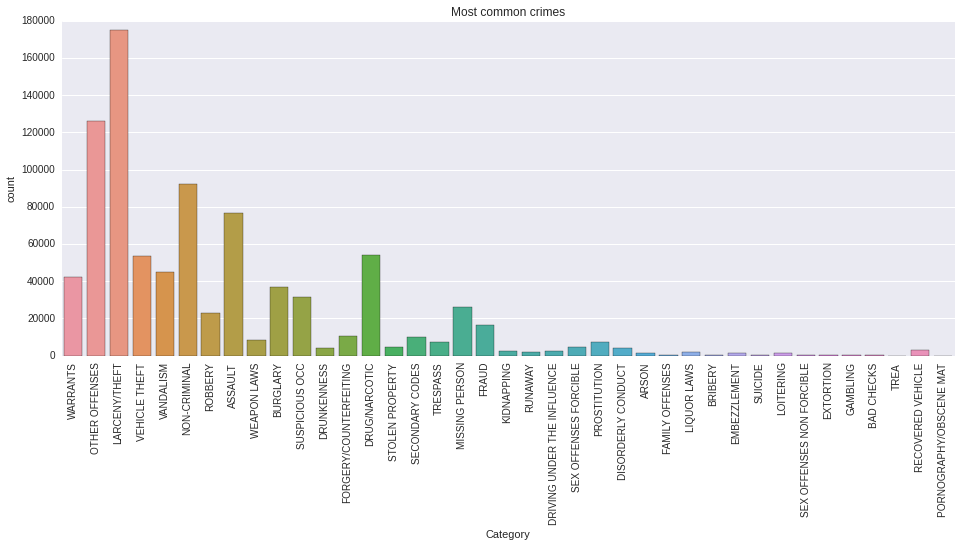

In [6]:
ax = sns.countplot(x="Category", data=train_df)
plt.sca(ax)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(16, 6, forward=True)
plt.title("Most common crimes")

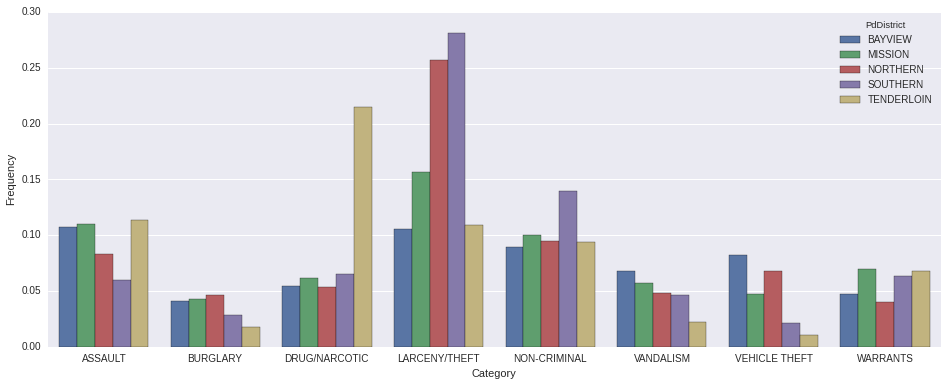

In [57]:
# most_common_cats = all_categories.drop("OTHER OFFENSES")[0:5]
# most_common_districts = train_df.PdDistrict.value_counts().index[0:8]
# district_df = train_df[train_df.Category.isin(most_common_cats) & train_df.PdDistrict.isin(most_common_districts)]
# ax = sns.countplot(x="PdDistrict", hue="Category", data=district_df)
# plt.gcf().set_size_inches(16, 6, forward=True)
# plt.title("Most common crime in each district")


most_common_cats = all_categories.drop("OTHER OFFENSES")[0:8]
most_common_districs = list(train_df.PdDistrict.value_counts().index[0:4])
most_common_districs.append('TENDERLOIN') # Because Tenderloin has all the drugs.

freqs = pd.DataFrame({'count' : train_df.groupby( ["Category", "PdDistrict"] ).size()}).reset_index()
wknd_totals = freqs.PdDistrict.map(dict(train_df.groupby( "PdDistrict" ).size()))
freqs["freq"] = freqs["count"].divide(wknd_totals)
freqs_filt = freqs[freqs.Category.isin(most_common_cats) & freqs.PdDistrict.isin(most_common_districs)]

sns.barplot(data=freqs_filt, x="Category", y="freq", hue="PdDistrict")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

### This graph shows the frequency for each crime in each district. Interesting that drugs make up rougly 6% of crimes in most districts, but 22% in Tenderloin.

### Let's check out if weekends are special:

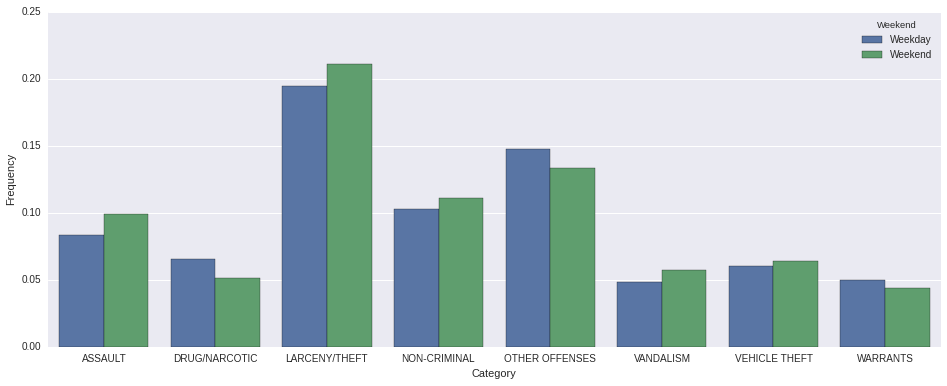

In [8]:
most_common_cats = all_categories[0:8]

freqs = pd.DataFrame({'count' : train_df.groupby( ["Category", "Weekend"] ).size()}).reset_index()
wknd_totals = freqs.Weekend.map(dict(train_df.groupby( "Weekend" ).size()))
freqs["freq"] = freqs["count"].divide(wknd_totals)
freqs_filt = freqs[freqs.Category.isin(most_common_cats)]

sns.barplot(data=freqs_filt, x="Category", y="freq", hue="Weekend")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

### Well that's disappointing. Maybe there's something special about Fridays and Saturdays?

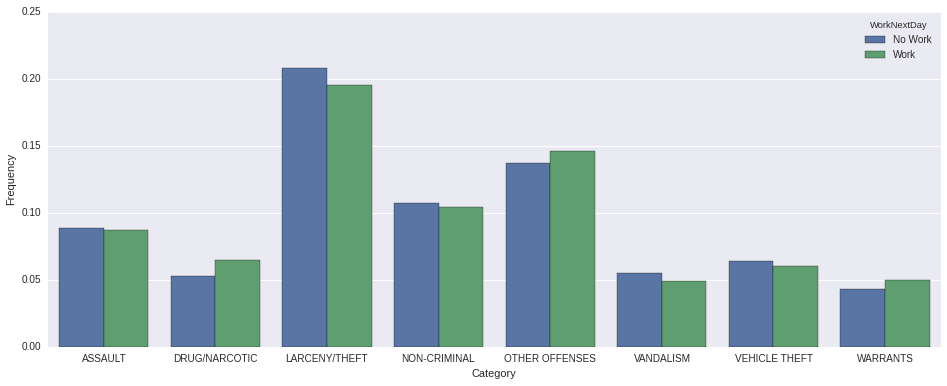

In [9]:
freqs = pd.DataFrame({'count' : train_df.groupby( ["Category", "WorkNextDay"] ).size()}).reset_index()
wknd_totals = freqs.WorkNextDay.map(dict(train_df.groupby( "WorkNextDay" ).size()))
freqs["freq"] = freqs["count"].divide(wknd_totals)
freqs_filt = freqs[freqs.Category.isin(most_common_cats)]

sns.barplot(data=freqs_filt, x="Category", y="freq", hue="WorkNextDay")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

### Nope again...Let's try plotting the frequency of each crime over the course of the days of the week:

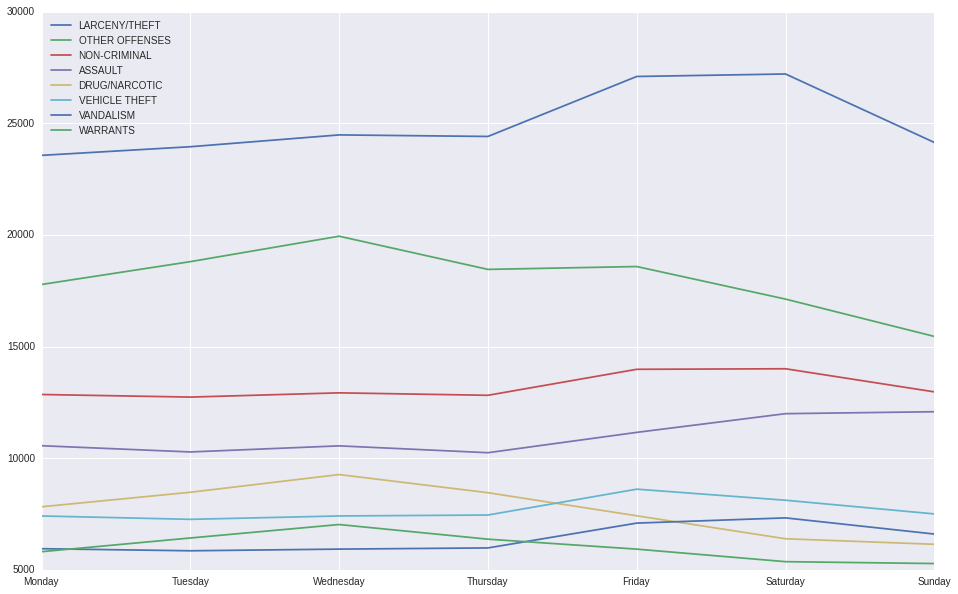

In [10]:
for c in all_categories[0:8]:
    subset = train_df[train_df.Category == c]
    groups = subset.groupby("DOW_Index")
    days = [g.DOW_Index.mean() for _, g in groups]
    crimes = [len(g) for _, g in groups]
    plt.plot(days, crimes, label=c)
plt.legend(loc=2)
plt.gcf().set_size_inches(16, 10, forward=True)
plt.gca().set_xticklabels(dow)

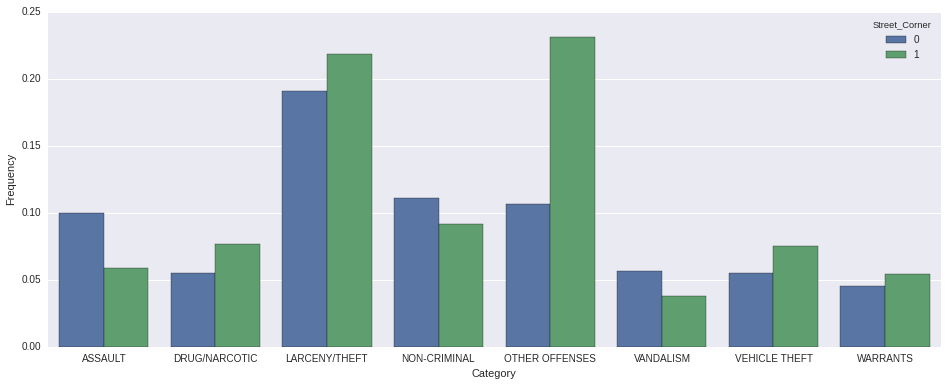

In [43]:
most_common_cats = all_categories[0:8]

freqs = pd.DataFrame({'count' : train_df.groupby( ["Category", "Street_Corner"] ).size()}).reset_index()
wknd_totals = freqs.Street_Corner.map(dict(train_df.groupby( "Street_Corner" ).size()))
freqs["freq"] = freqs["count"].divide(wknd_totals)
freqs_filt = freqs[freqs.Category.isin(most_common_cats)]

sns.barplot(data=freqs_filt, x="Category", y="freq", hue="Street_Corner")
plt.ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

### This is interesting. Assults don't happen on street corners, other offenses do. Let's see more granularity in our data.

### Let's investigate time of day

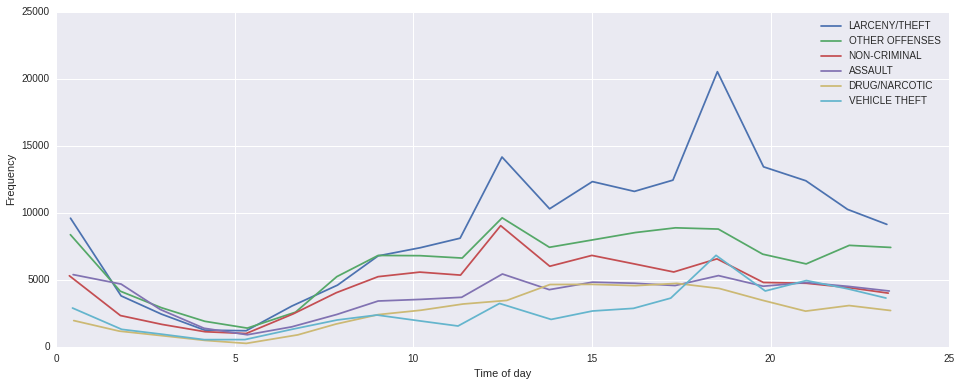

In [11]:
bins = np.linspace(0, 24, 20, False)
for c in all_categories[0:6]:
    subset = train_df[train_df.Category == c]
    indices = np.digitize(subset.Hour_Minutes, bins)
    groups = subset.groupby(indices)
    times = [g.Hour_Minutes.mean() for i, g in groups]
    crimes = [len(g) for i, g in groups]
    plt.plot(times, crimes, label=c)
plt.legend()
plt.gcf().set_size_inches(16, 6, forward=True)
plt.ylabel("Frequency")
plt.xlabel("Time of day")

### It seems like time of day is specifically important for Larceny/Theft. Let's investigate time of day's effect on each day:

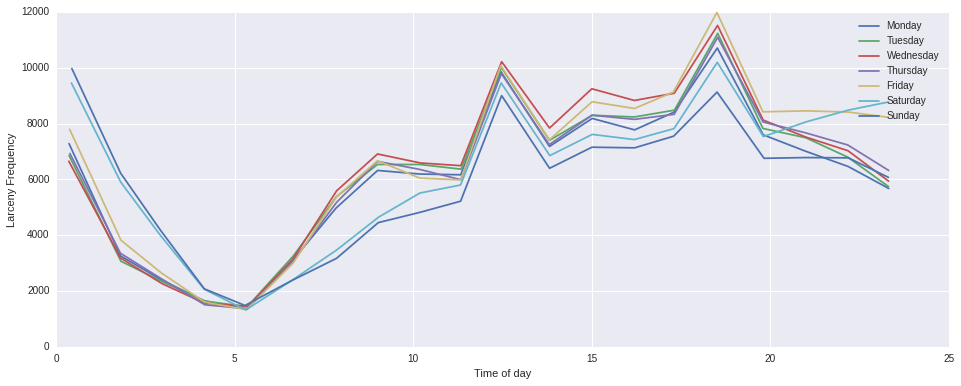

In [12]:
bins = np.linspace(0, 24, 20, False)
for d in dow:
    subset = train_df[train_df.DayOfWeek == d]
    indices = np.digitize(subset.Hour_Minutes, bins)
    groups = subset.groupby(indices)
    times = [g.Hour_Minutes.mean() for i, g in groups]
    crimes = [len(g) for i, g in groups]
    plt.plot(times, crimes, label=d)
plt.legend()
plt.gcf().set_size_inches(16, 6, forward=True)
plt.ylabel("Larceny Frequency")
plt.xlabel("Time of day")

### It's kinda interesting from roughly 8pm-6am Larceny is a lot more common on weekends, and from 6am-12pm it's more common on weekdays.

### Let's explore the location variables in our data set. First, we create some helper functions for making a hexbin graph, and then for comparing day vs. night and weekend vs. weekday.

In [41]:
def hexbin_image(df, title=None, color=plt.cm.Blues, vmax=250, cat=None):
    
    if (cat is not None):
        df = df[df.Category == cat]
    
    lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

    imgplot = plt.imshow(mapdata, cmap=plt.get_cmap('gray'),extent=lon_lat_box)
    plt.hexbin(df.X, df.Y, gridsize=40, cmap=color,
               extent=lon_lat_box, alpha=0.5, vmin=0, vmax=vmax)
    if (title is None):
        print 'hello'
        plt.title('%s by Location' % df.Category.mode().values[0])
    else:
        plt.title(title)
        
def day_vs_night_plot(df, cat=None):
    if (cat is not None):
        df = df[df.Category == cat]
    f, axtuple = plt.subplots(1, 2, sharey=True)
    colors = {"Day": plt.cm.Oranges, "Night": plt.cm.Blues}
    for i, light in enumerate(["Day", "Night"]):
        subset = df[df.DayorNight == light]
        plt.sca(axtuple[i])
        hexbin_image(subset, title='%s during the %s' % (df.Category.mode().values[0], light), color=colors[light])        

def weekday_weekend_plot(df, cat=None):
    if (cat is not None):
        df = df[df.Category == cat]
    f, axtuple = plt.subplots(1, 2, sharey=True)
    colors = {"Weekend": plt.cm.Greens, "Weekday": plt.cm.Purples}
    for i, day in enumerate(["Weekday", "Weekend"]):
        subset = df[df.Weekend == day]
        plt.sca(axtuple[i])
        hexbin_image(subset, title='%s during the %s' % (df.Category.mode().values[0], day), color=colors[day])

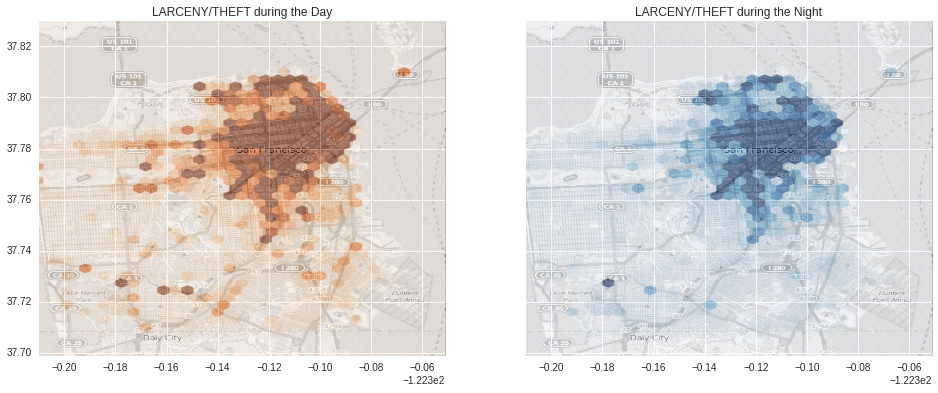

In [42]:
day_vs_night_plot(train_df, cat="LARCENY/THEFT")
plt.gcf().set_size_inches(16, 6)

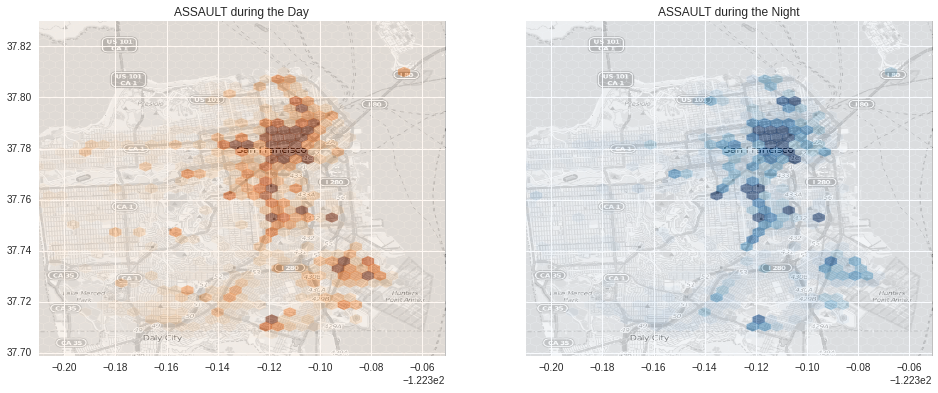

In [32]:
day_vs_night_plot(train_df, cat="ASSAULT")
plt.gcf().set_size_inches(16, 6)

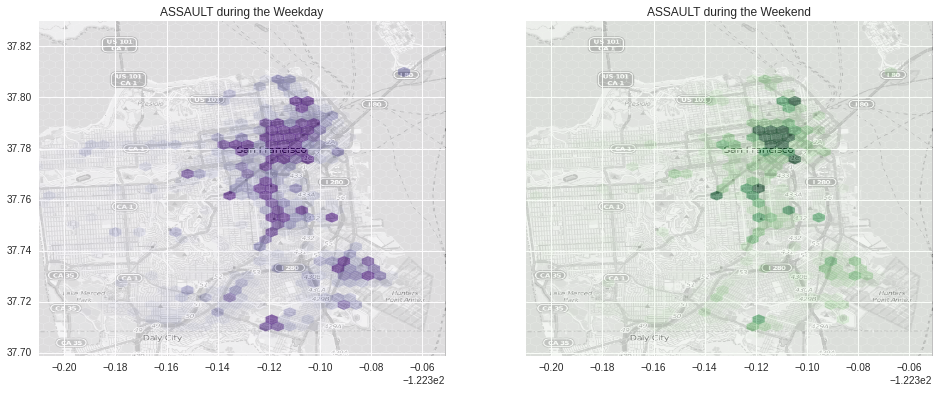

In [33]:
weekday_weekend_plot(train_df, cat="ASSAULT")
plt.gcf().set_size_inches(16, 6)

In [34]:
def heat_plot(df, category):
    y, x = np.mgrid[0:25, 0:8]
    z = np.zeros(y.shape)
    grouped = train_df.groupby("Category")
    subset = grouped.get_group(category)
    more_groups = subset.groupby(["DOW_Index", "Hour"])
    for name, group in more_groups:
        z[name[1], name[0]] = len(group)
    plt.pcolor(x, y, z, cmap='YlOrRd')
    plt.gca().set_xticklabels(dow)
    plt.ylabel("Hour")
    plt.title("Day-time distribution of %s" % category)
    plt.axis([x.min(), x.max(), y.min(), y.max()])

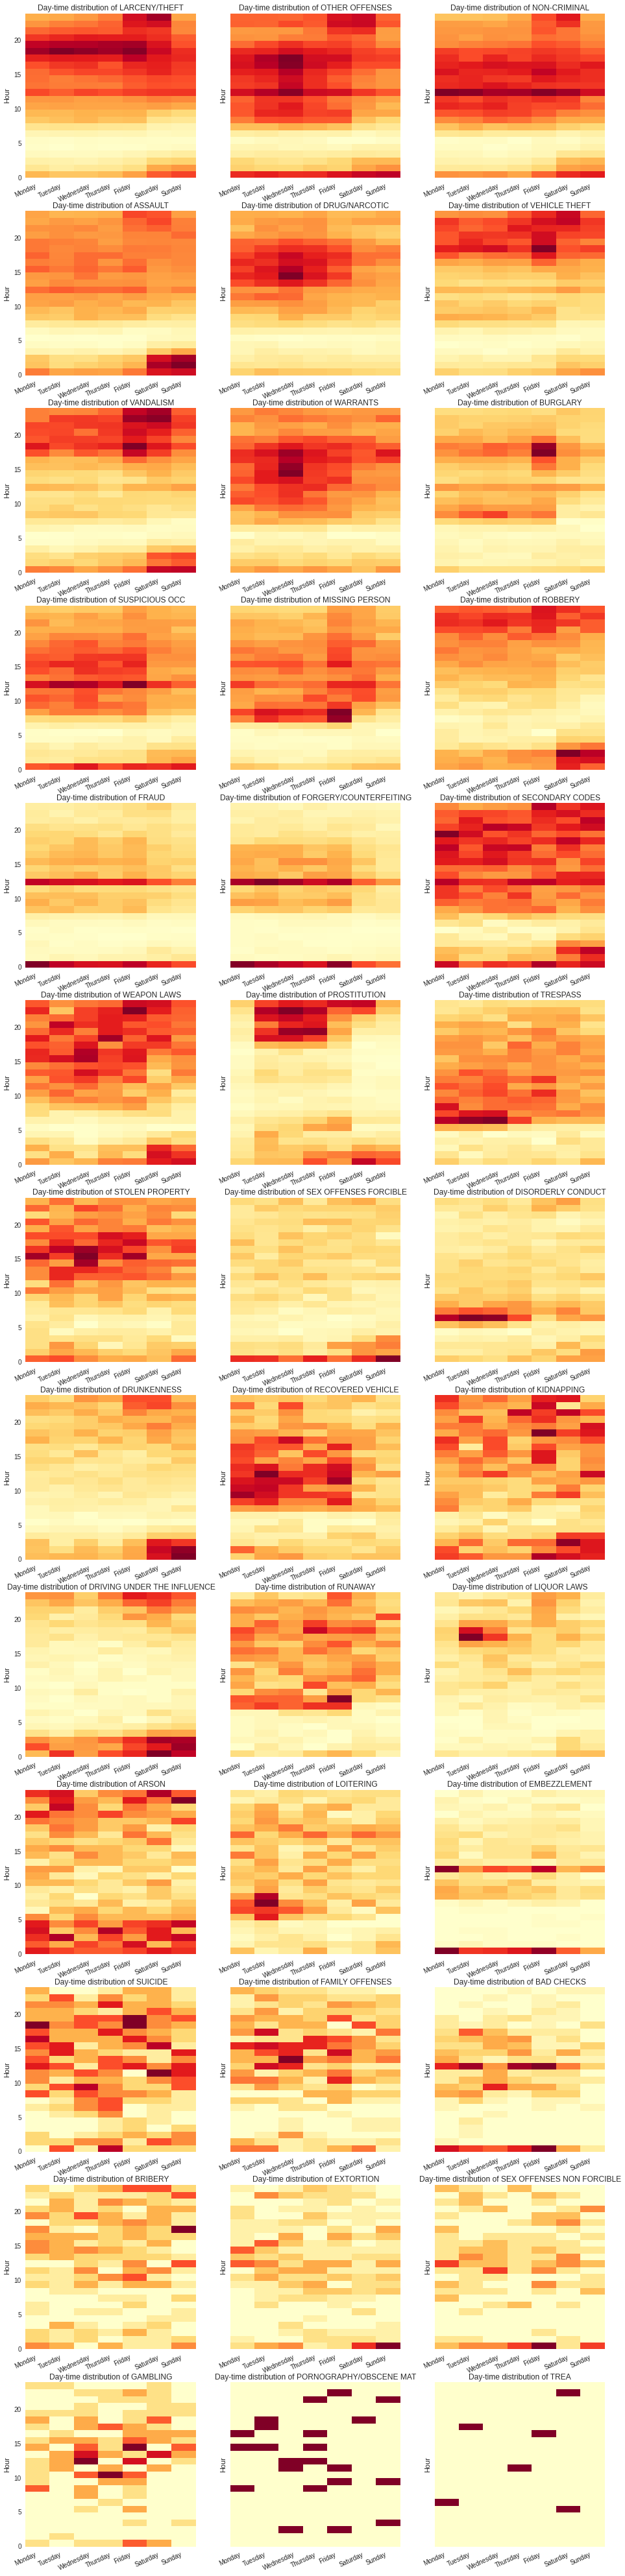

In [37]:
padded = all_categories.tolist()
while (len(padded) < 13*3):
    padded.append(None)
cat_array = np.reshape(padded, (13, 3))
f, axtuple = plt.subplots(cat_array.shape[0], cat_array.shape[1], sharey=True)
rows, cols = cat_array.shape

for j in range(rows):
    for i in range(cols):
        cat = cat_array[j, i]
        if (cat is not None):
            plt.sca(axtuple[j][i])
            heat_plot(train_df, cat)
            plt.xticks(rotation=25)
plt.gcf().set_size_inches(16, 70)

### For certain crimes it seems like noon and midnight are special, presumably because that's when the crimes 

## Machine Learning time

### These are some helper functions we'll use later to give our models the parameters we want.

In [44]:
def get_x_matrix(df, formula):
    x_vals = dmatrix(formula, data=df, return_type='dataframe')
    return x_vals
        
def get_x_y_matrices(df, formula, target, filt=True):
    
    x_vals = dmatrix(formula, data=df, return_type='dataframe')
    y_vals = df[target]
    if (filt):
        return filter_infrequent(x_vals, y_vals)
    return x_vals, y_vals
    
def filter_infrequent(x, y, threshold=3):
    counts = y.value_counts()
    for cat, count in counts.iteritems():
        if count < 3:
            x = x[y != cat]
            y = y[y != cat]
            
    return x, y

### Let's try a basic RandomForest

In [ ]:
formula_ml = 'C(DayOfWeek) + C(PdDistrict) + C(Street_Corner) + X+Y+Hour+Month'

x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')
min_leaves = np.round_(np.logspace(1, 3.5, num=6)) # values from 10 to 3100

parameters = {'min_samples_leaf':min_leaves}

clf = GridSearchCV(RandomForestClassifier(), parameters, scoring='log_loss')

clf.fit(x_vals, y_vals)

for f in clf.grid_scores_:
    print f

In [48]:
formula_ml = 'C(DayOfWeek) + C(PdDistrict) + C(Street_Corner) + X+Y+Hour+Month'

x_vals, y_vals = get_x_y_matrices(train_df, formula_ml, 'Category')
min_leaves = np.round_(np.logspace(1, 3.5, num=6)) # values from 10 to 3100

parameters = {'min_samples_leaf':min_leaves}

clf = GridSearchCV(RandomForestClassifier(), parameters, scoring='log_loss')

clf.fit(x_vals, y_vals)

for f in clf.grid_scores_:
    print f

mean: -3.32426, std: 0.11502, params: {'min_samples_leaf': 10.0}
mean: -2.75315, std: 0.03946, params: {'min_samples_leaf': 32.0}
mean: -2.64276, std: 0.04784, params: {'min_samples_leaf': 100.0}
mean: -2.61362, std: 0.01135, params: {'min_samples_leaf': 316.0}
mean: -2.66203, std: 0.01050, params: {'min_samples_leaf': 1000.0}
mean: -2.67149, std: 0.00831, params: {'min_samples_leaf': 3162.0}
